Saved {} lines 226
Number of data examples: 214
Batch size for dataset 6
[1001202. 1004868.       0.] [-3. -4.  0.] [-3. -4.  0.] [-3.  0.  0.]


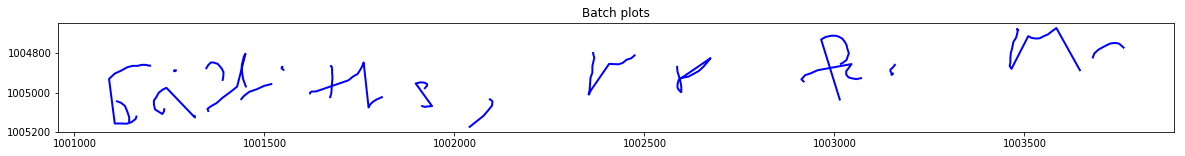

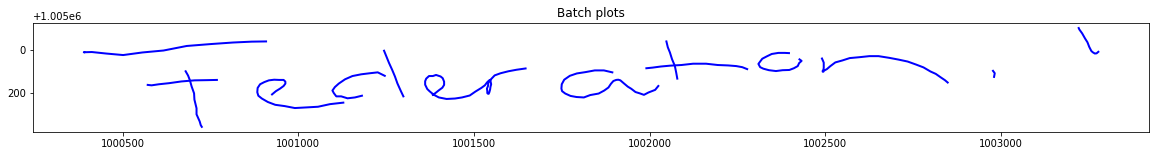

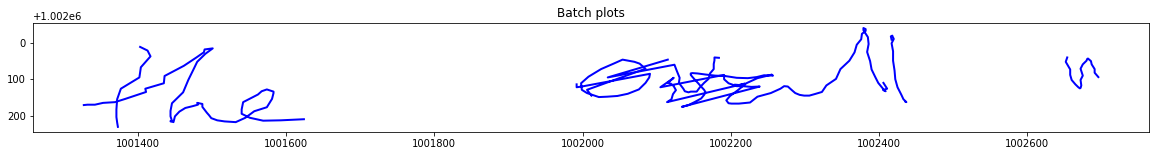

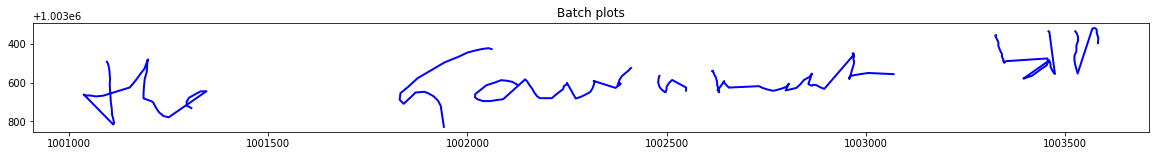

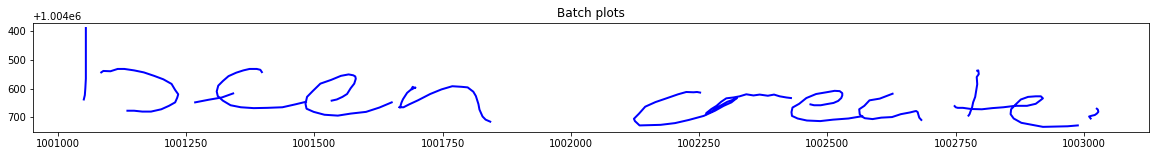

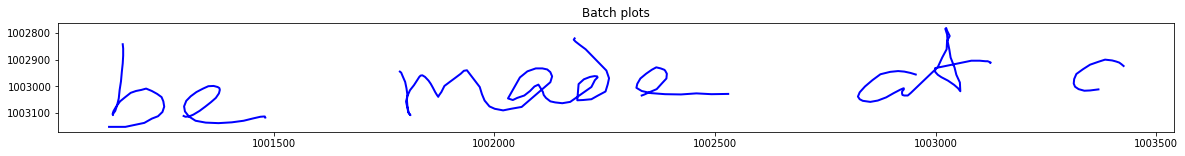

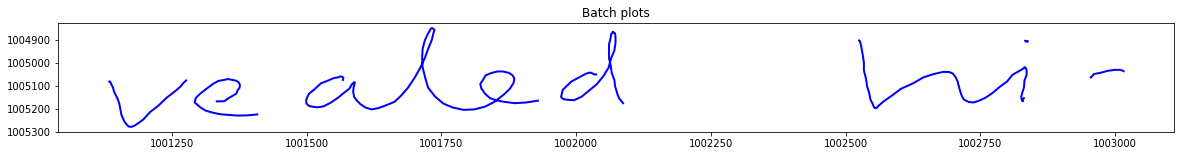

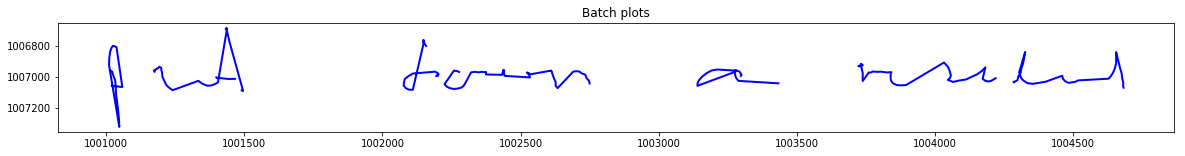

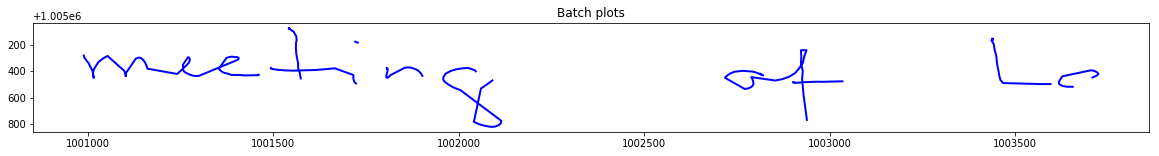

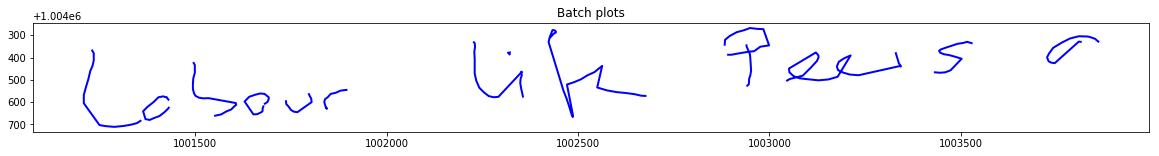

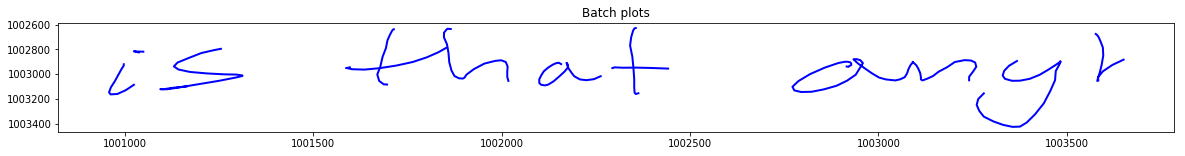

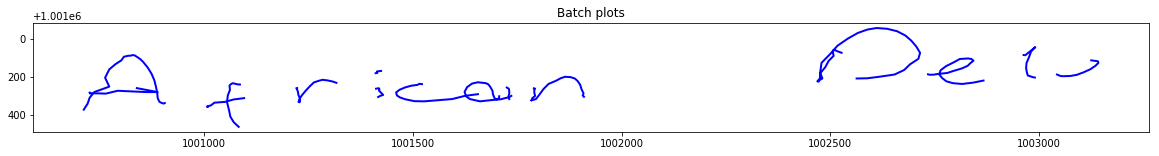

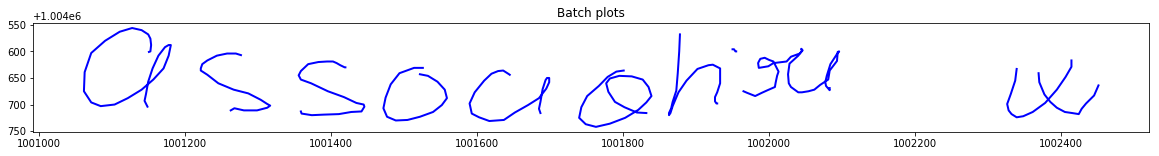

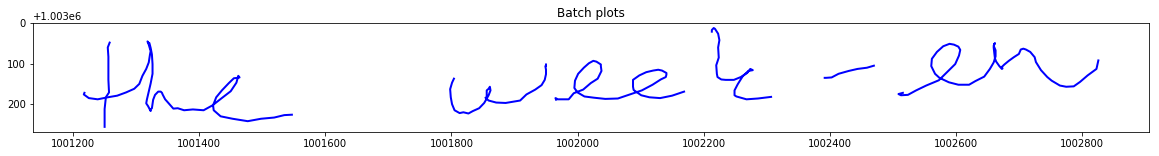

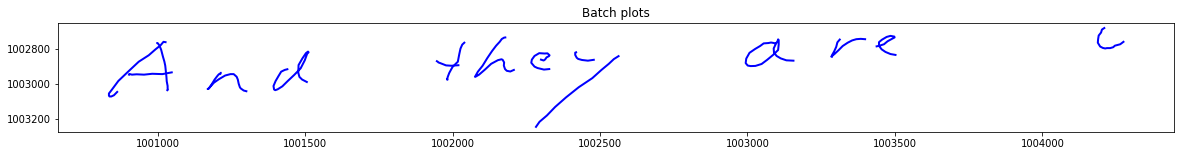

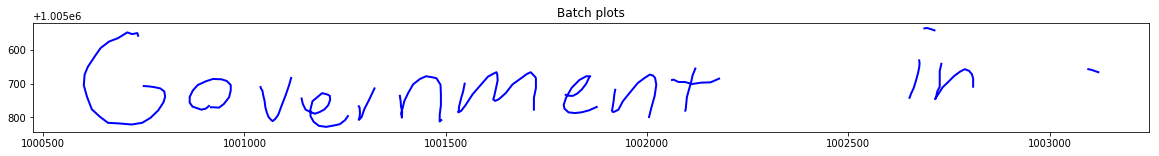

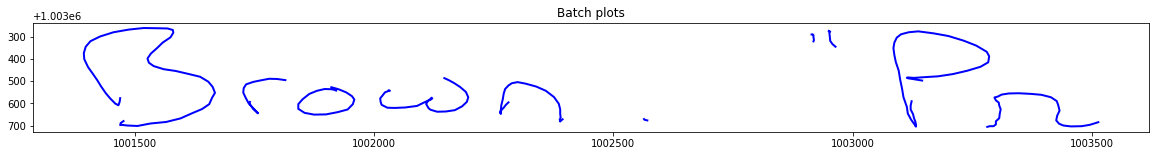

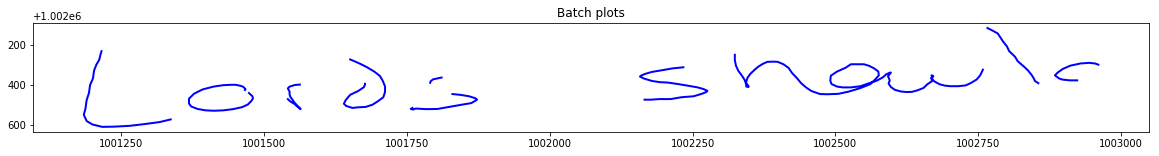

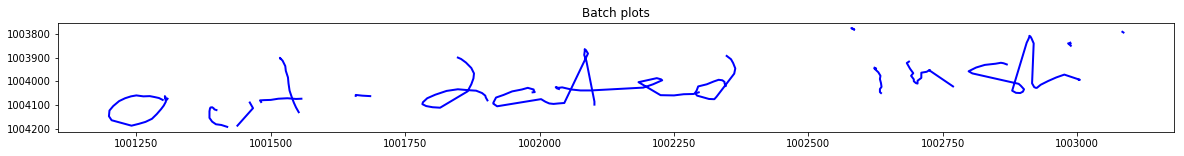

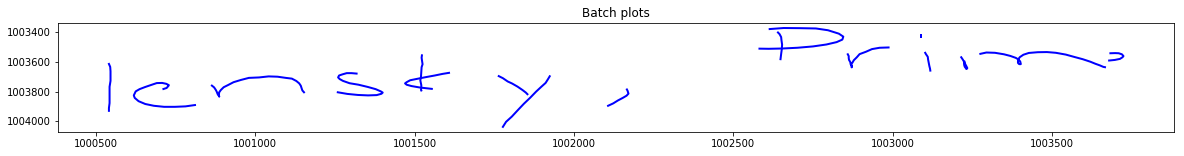

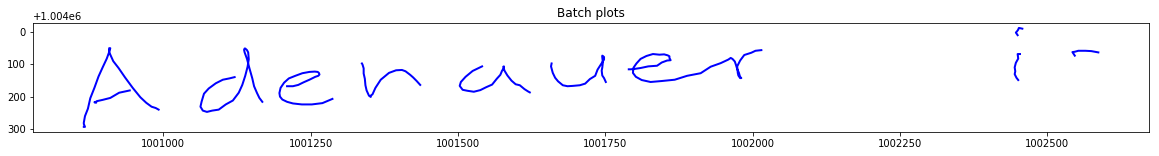

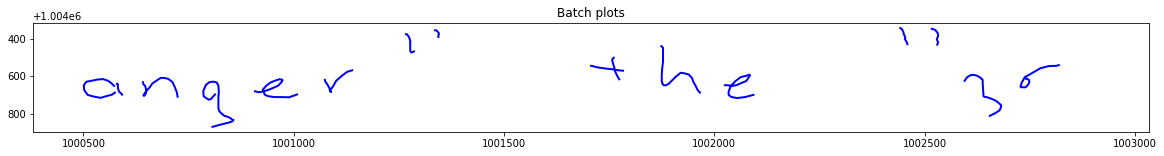

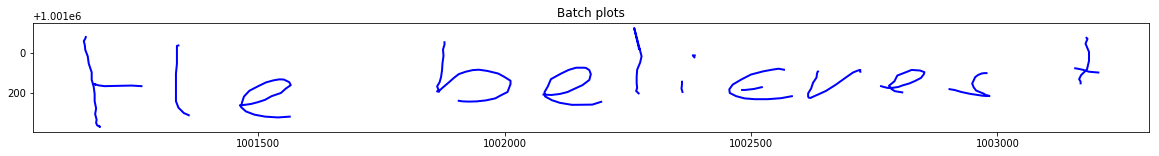

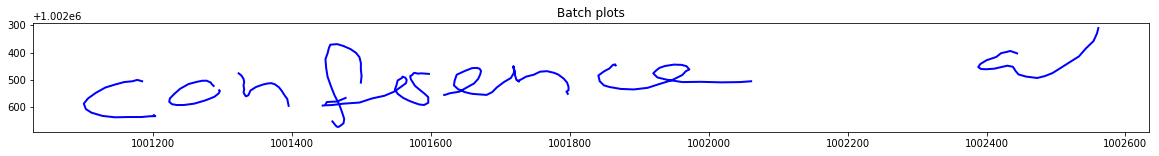

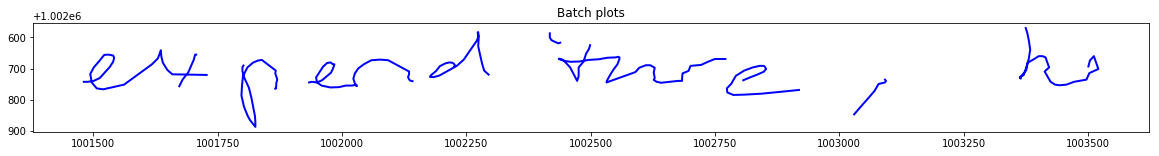

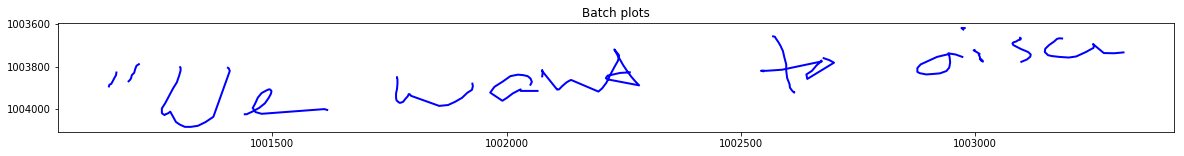

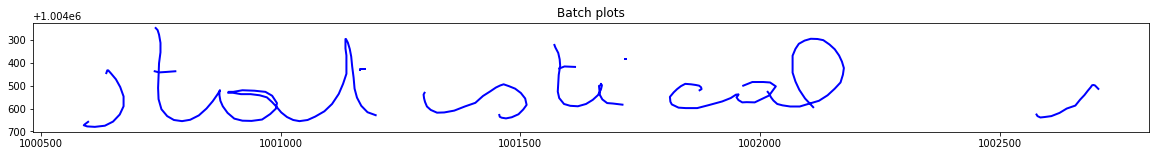

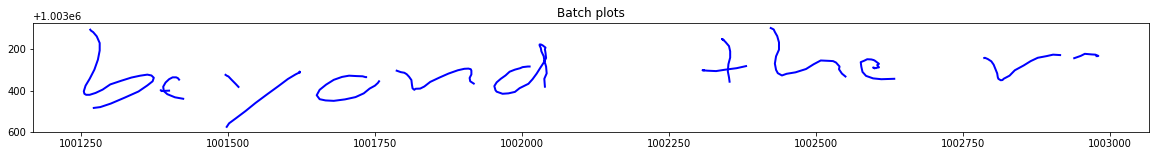

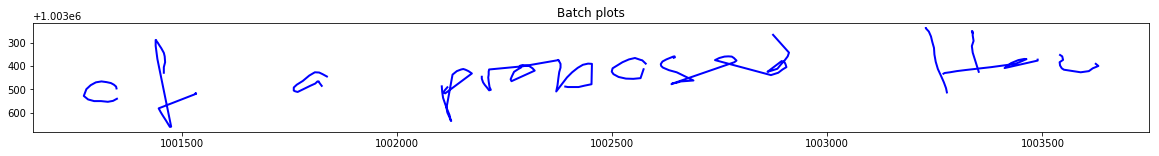

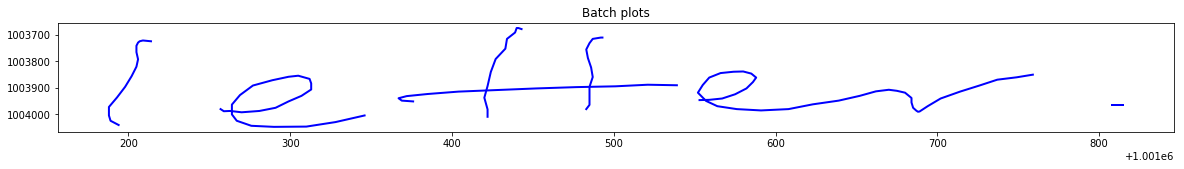

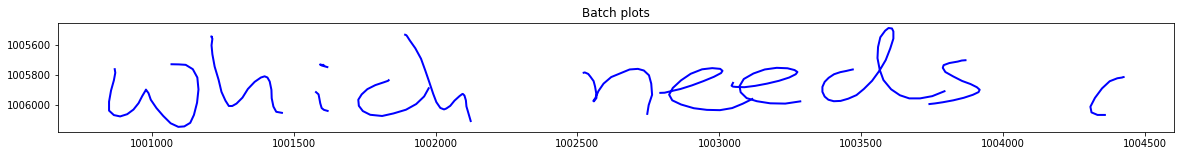

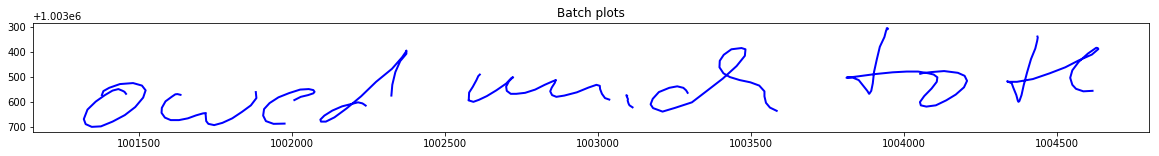

In [1]:
import numpy as np
import tensorflow as tf

import argparse
import time
import os


# from LSTM import Model
# from LSTM import load_pretrained_model
import LSTM
from LSTM import *
from importlib import reload
reload(LSTM)
from dataloader import DataProcess
from sample import *

In [2]:
def init_args():
    
        args = {}
        args['rnn_size'] = 100 
        args['tsteps'] = 256 
        args['batch_size'] = 32
        args['num_batches'] = 32 
        args['num_mixtures'] = 8 
        args['alphabet'] = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        args['tsteps_per_ascii'] = 25
        args['epochs'] = 100
        args['path'] = 'saved2/model.ckpt'
        args['biases'] = 1.0
        args['logs_dir'] = './logs/'
        args['save_path'] = 'saved2/model.ckpt'
        args['sleep_time'] = 60*5
        args['grad_clip'] = 10
        args['n_to_save'] = 500
        return args

def load_pretrained_model(model, path):
        global_step = 0
        load_was_success = True
        try:
            save_dir = '/'.join(path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            model.saver.restore(model.sess, load_path)
            #load_was_success = True
        except Exception as e:
            #print(e)
            load_was_success = False
        else:
            model.saver = tf.train.Saver(tf.global_variables())
            global_step = int(load_path.split('-')[-1])
            load_was_success = True
        return load_was_success, global_step
    
def train_model():
    sess = tf.Session()
    data_loader = DataProcess()
    args = init_args()
    model = Model(args)
    load_was_success, global_step = load_pretrained_model(model, args['save_path'])
    v_x, v_y = data_loader.get_validation_data()
    valid_inputs = {model.input: v_x, model.output: v_y}
    
    for e in range(int(global_step/args['num_batches']), args['epochs']):

        c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
        h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()

        for b in range(global_step%args['num_batches'], args['num_batches']):
            print(b)

            i = e * args['num_batches'] + b
            if global_step is not 0 : i+=1 ; global_step = 0

            if i % args['n_to_save'] == 0 and (i > 0):
                model.saver.save(model.sess, args['save_path'], global_step = i) ; logger.write('SAVED MODEL')

            start = time.time()
            x, y = data_loader.get_next_batch()

            feed = {model.input: x, model.output: y, \
                    model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                    model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}

            [train_loss, _] = model.sess.run([model.cost, model.train_op], feed)
            feed.update(valid_inputs)
            [valid_loss] = model.sess.run([model.cost], feed)
            
            running_average = running_average*remember_rate + train_loss*(1-remember_rate)

            end = time.time()
            if i % 10 is 0: logger.write("{}/{}, loss = {:.3f}, regloss = {:.5f}, valid_loss = {:.3f}, time = {:.3f}" \
                .format(i, args['epochs'] * args['num_batches'], train_loss, running_average, valid_loss, end - start) )

def sample_model(logger=None):
    args = init_args()
#     if args['text'] == '':
    strings = ['Machine generated handwriting'] # test strings
#     else:
#         strings = [args['text']]

    model = Model(args)

    load_was_success, global_step = load_pretrained_model(model, args['save_path'])

    if load_was_success:
        for s in strings:
            strokes = sample(s, model, args)

            w_save_path = '{}figures/iter-{}-w-{}'.format(args['logs_dir'], global_step, s[:10].replace(' ', '_'))
            g_save_path = '{}figures/iter-{}-g-{}'.format(args['logs_dir'], global_step, s[:10].replace(' ', '_'))
            l_save_path = '{}figures/iter-{}-l-{}'.format(args['logs_dir'], global_step, s[:10].replace(' ', '_'))

            gauss_plot(strokes, 'Heatmap for "{}"'.format(s), figsize = (2*len(s),4), save_path=g_save_path)
            line_plot(strokes, 'Line plot for "{}"'.format(s), figsize = (len(s),2), save_path=l_save_path)

    else:
        print("load failed, sampling canceled")

    if True:
        tf.reset_default_graph()
        time.sleep(args['sleep_time'])
        sample_model(logger=logger)

            
            
            
            
            
            
            
            
            
    

In [3]:
train_model()

Saved {} lines 226
Number of data examples: 214
Batch size for dataset 6

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from saved2/model.ckpt
0
[1000391. 1001844.       0.] [-9. 17.  0.] [-9. 17.  0.] [0. 4. 0.]


AttributeError: 'Model' object has no attribute 'input_data'